## Project Preview
练习：星巴克

<br>
<br>
 
#### 背景信息

此练习将提供一个数据集，星巴克原先使用该数据集作为面试题。这道练习的数据包含 120,000 个数据点，按照 2:1 的比例划分为训练文件和测试文件。数据模拟的实验测试了一项广告宣传活动，看看该宣传活动能否吸引更多客户购买定价为 10 美元的特定产品。由于公司分发每份宣传资料的成本为 0.15 美元，所以宣传资料最好仅面向最相关的人群。每个数据点都有一列表示是否向某个人发送了产品宣传资料，另一列表示此人最终是否购买了该产品。每个人还有另外 7 个相关特征，表示为 V1-V7。

#### 优化策略

你的任务是通过训练数据了解 V1-V7 存在什么规律表明应该向用户分发宣传资料。具体而言，你的目标是最大化以下指标：

* **增量响应率 (IRR)** 

IRR 表示与没有收到宣传资料相比，因为推广活动而购买产品的客户增加了多少。从数学角度来说，IRR 等于推广小组的购买者人数与购买者小组客户总数的比例 (_treatment_) 减去非推广小组的购买者人数与非推广小组的客户总数的比例 (_control_)。

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **净增量收入 (NIR)**

NIR 表示分发宣传资料后获得（丢失）了多少收入。从数学角度来讲，NIR 等于收到宣传资料的购买者总人数的 10 倍减去分发的宣传资料份数的 0.15 倍，再减去没有收到宣传资料的购买者人数的 10 倍。

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

要详细了解星巴克提供给应聘者的数据集，请参阅[此处的说明](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM)。

下面是训练数据。研究数据和不同的优化策略。

#### 如何测试你的策略？

如果你想到了优化策略，请完成要传递给 `test_results` 函数的 `promotion_strategy` 函数。  
根据以往的数据，我们知道有四种可能的结果：

实际推广客户与预测推广客户表格：  

<table>
<tr><th></th><th colspan = '2'>实际</th></tr>
<tr><th>预测</th><th>是</th><th>否</th></tr>
<tr><th>是</th><td>I</td><td>II</td></tr>
<tr><th>否</th><td>III</td><td>IV</td></tr>
</table>

我们仅针对预测应该包含推广活动的个人比较了指标，即第一象限和第二象限。由于收到宣传资料的第一组客户（在训练集中）是随机收到的，因此第一象限和第二象限的参与者人数应该大致相同。  

比较第一象限与第二象限可以知道宣传策略未来效果如何。 

首先阅读以下数据。看看每个变量或变量组合与推广活动对购买率有何影响。你想到谁应该接收宣传资料的策略后，请使用在最后的 `test_results` 函数中使用的测试数据集测试你的策略。

## Data Prepare

In [35]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

# xgboost 和 sklearn中的xgboost是相同的
#https://zhuanlan.zhihu.com/p/31182879
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import wrangling3 as w;

In [2]:
help(w)

Help on module wrangling3:

NAME
    wrangling3

DESCRIPTION
    function list:
    1 /check df/
    -1.1 checkdf(df) - 基准df信息输出
    -1.2 checksample(df,random=42) - 对于列信息很多或者嵌套的,详细输出一个
    2 /check column/
    -2.1 checknest(df,colname) - 嵌套diclike信息输出
    -2.2 checkvalue(df,list='all') - 检查指定列的value分布
    3 /alter data/
    -3.1 dorpcolumn(df,collist) - 删除列

FUNCTIONS
    checkdf(df)
        input: dataframe which to exam
        
        check:
        shape, info, head, tail, null
        for some feature are long and can not be show full length,
        so use this function to see all in detail.
        
        output: str
    
    checkdup(df)
        input: dataframe which to exam
        
        check:
        duplicated info of the data,
        if there are columns contain interabel, will enconter a error,
        use try/except to warining if so.
        
        output: str
    
    checknest(df, colname)
        input: 
        1 dataframe which to exam
        2 column 

In [3]:
# check data train
## load data
train = pd.read_csv('./training.csv')

## snip data
print('---snip data---')
display(train.head())

### check null (null will bring errors)
print('---check null---')
display(train.isnull().mean())

print('---check shape---')
print(train.shape)

---snip data---


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


---check null---


ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

---check shape---
(84534, 10)


<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

In [4]:
# check data test
## load data
test = pd.read_csv('./Test.csv')

## snip data
print('---snip data---')
display(test.head())

### check null (null will bring errors)
print('---check null---')
display(test.isnull().mean())

print('---check shape---')
print(test.shape)

test_data = pd.read_csv('./Test.csv')
test_data.head()

---snip data---


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


---check null---


ID           0.0
Promotion    0.0
purchase     0.0
V1           0.0
V2           0.0
V3           0.0
V4           0.0
V5           0.0
V6           0.0
V7           0.0
dtype: float64

---check shape---
(41650, 10)


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.376390,1.172517,1,1,2,2
1,6,Yes,0,1,25.163598,0.653050,2,2,2,2
2,7,Yes,0,1,26.553778,-1.597972,2,3,4,2
3,10,No,0,2,28.529691,-1.078506,2,3,2,2
4,12,No,0,2,32.378538,0.479895,2,2,1,2


In [5]:
# check values
## Promotion give us the experiment distribution information
checklist = ['Promotion','purchase','V4','V5','V6','V7']
featurelist = ['V1','V2','V3','V4','V5','V6','V7']
w.checkvalue(train,checklist)


-check column value: ---Promotion----
largest:
 Yes    42364
No     42170
Name: Promotion, dtype: int64
smallest
: No     42170
Yes    42364
Name: Promotion, dtype: int64

-check column value: ----purchase----
largest:
 0    83494
1     1040
Name: purchase, dtype: int64
smallest
: 1     1040
0    83494
Name: purchase, dtype: int64

-check column value: -------V4-------
largest:
 2    57450
1    27084
Name: V4, dtype: int64
smallest
: 1    27084
2    57450
Name: V4, dtype: int64

-check column value: -------V5-------
largest:
 3    32743
2    31196
1    15412
4     5183
Name: V5, dtype: int64
smallest
: 4     5183
1    15412
2    31196
3    32743
Name: V5, dtype: int64

-check column value: -------V6-------
largest:
 3    21186
4    21176
2    21146
1    21026
Name: V6, dtype: int64
smallest
: 1    21026
2    21146
4    21176
3    21186
Name: V6, dtype: int64

-check column value: -------V7-------
largest:
 2    59317
1    25217
Name: V7, dtype: int64
smallest
: 1    25217
2    59317
N

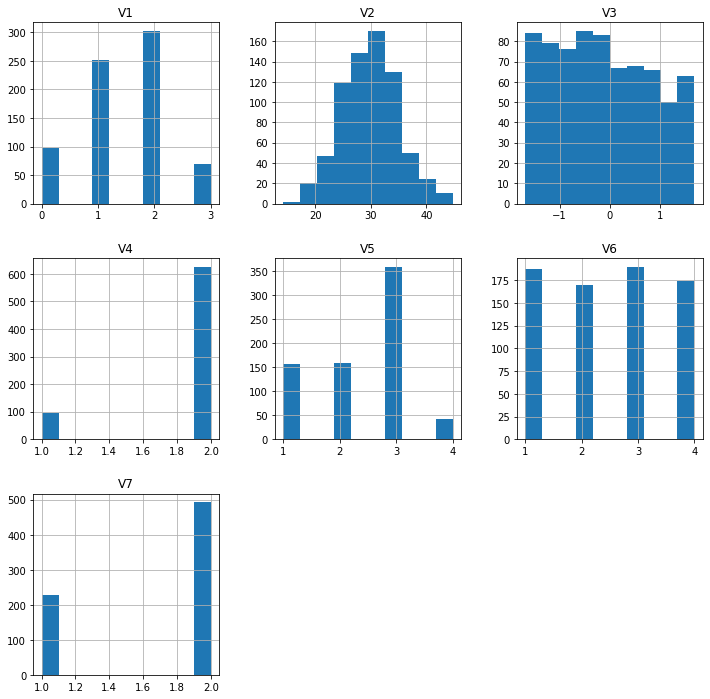

In [6]:
# check distribution treatment
train.query('Promotion == "Yes" and purchase == 1') \
[featurelist].hist(figsize=(12,12));

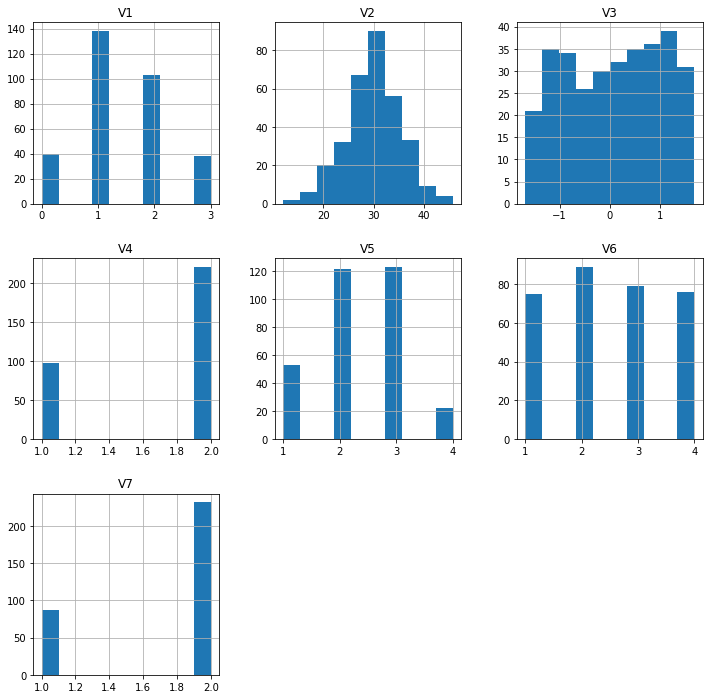

In [7]:
# check distribution control
train.query('Promotion == "No" and purchase == 1') \
[featurelist].hist(figsize=(12,12));

## Promotion Functions
from [/Link/](https://github.com/joshxinjie/Data_Scientist_Nanodegree/blob/master/starbucks_portfolio_exercise/Starbucks.ipynb)

### Model1
Predict only for indivduals who received promotions and purchased

In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. In other words, we want the model to find the individuals who are likely to purchase only after they received a promotion. 

This is a simple model that surprisingly performed relatively well for this dataset, generating an incremental response rate (IRR) of 2.19% and a net incrmental revenue (NLR) of $332.70. 

This actually outperformed the Starbuck's model for this dataset, which was an irr of 1.88% and an nlr of $189.45. 

However, since the IRR and NLR on the validation set is lower at 1.93% and $94.70,the model's relatively good performance on the test set may be due to random chance. Overall, it still performed superbly for such a simple model.

In [8]:
display(train.head(1))
display(test.head(1))

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2


,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,2,No,0,1,41.37639,1.172517,1,1,2,2


In [12]:
# generate labels
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0

response = []

for index, row in train.iterrows():
    if (row['purchase'] == 1) and (row['Promotion']=='Yes'):
        response.append(1)
    else:
        response.append(0)
        
train['response'] = response

In [14]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train, test_size=0.2,random_state=42)

In [17]:
# generate features and labels
Y_train = train['response']
X_train = train[featurelist]

Y_valid = valid['response']
X_valid = valid[featurelist]

In [18]:
Y_train.value_counts()

0    53621
1      480
Name: response, dtype: int64

In [23]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=featurelist)
Y_train_upsamp = pd.Series(Y_train_upsamp)
# SMOTE 是对较少抽样样本的模拟增加
# https://blog.csdn.net/march_on/article/details/48650237

In [25]:
len(X_train), len(X_train_upsamp), len(Y_train), len(Y_train_upsamp), 

(54101, 107242, 54101, 107242)

In [26]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.90554	validation_1-auc:0.668509
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.916856	validation_1-auc:0.682458
[2]	validation_0-auc:0.915486	validation_1-auc:0.683165
[3]	validation_0-auc:0.916487	validation_1-auc:0.682907
[4]	validation_0-auc:0.913747	validation_1-auc:0.68711
[5]	validation_0-auc:0.936165	validation_1-auc:0.687789
[6]	validation_0-auc:0.945673	validation_1-auc:0.683324
[7]	validation_0-auc:0.946531	validation_1-auc:0.688141
[8]	validation_0-auc:0.95512	validation_1-auc:0.686638
[9]	validation_0-auc:0.95772	validation_1-auc:0.689637
[10]	validation_0-auc:0.961401	validation_1-auc:0.686911
[11]	validation_0-auc:0.962014	validation_1-auc:0.686832
[12]	validation_0-auc:0.964243	validation_1-auc:0.683084
[13]	validation_0-auc:0.968168	validation_1-auc:0.681954
[14]	validation_0-auc:0.970283	validation_1-auc:0.681871
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

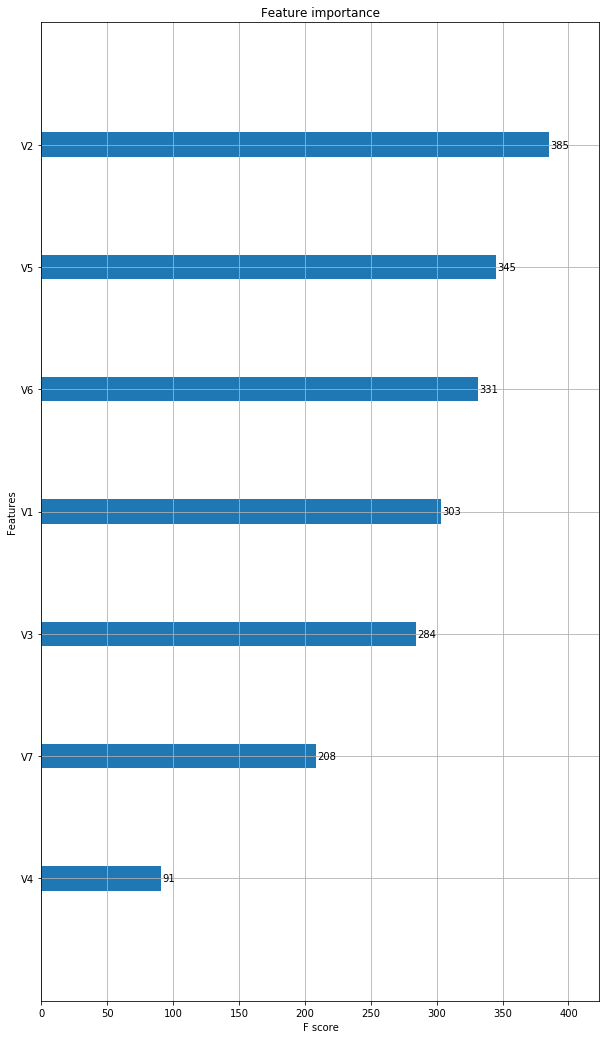

In [27]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [28]:
# confusion matrix
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[11661,  1765],
       [   77,    23]])

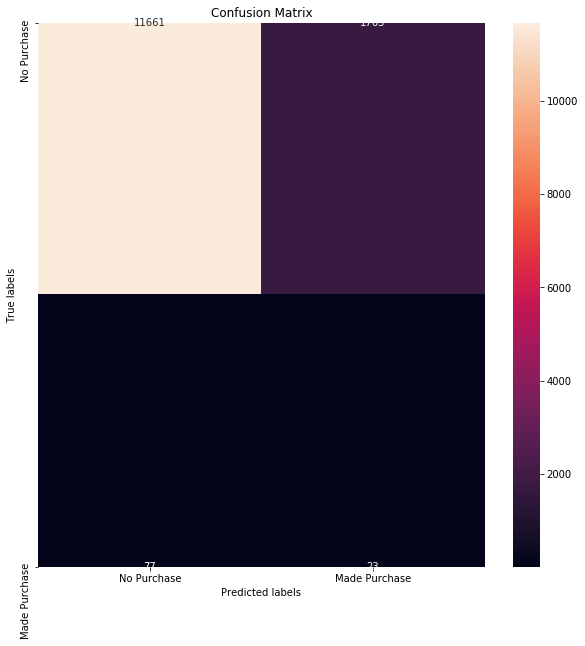

In [29]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [30]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [36]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0185.

Your nir with this strategy is 82.25.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018487475225063877, 82.25)

### Model 2: Using Two Models

In this approach, we will train two models. One model will be trained on the treatment group (those who received the promotion) and we will refer to this model as the treatment model. Another model will be trained on the control group (those who did not received the promotion), and we will refer to this as the control model. The target of both models will be whether the individual made the purchase or not. The treatment model will predict the probability that individual will make a purchase if he or she received the promotion, while the control model will predict the probability that individual will make a purchase if he or she did not receive the promotion. Ideally the difference in the probabilities, which we will call the lift:

![$$ Lift = P(purchase | treatment) - P(purchase | control) $$](https://render.githubusercontent.com/render/math?math=Lift%20%3D%20P%28purchase%20%7C%20treatment%29%20-%20P%28purchase%20%7C%20control%29&mode=display)

will tell us the probability that sending a promotion to an individual will increase his or her willingness to make a purhcase vs not sending a promotion. We can then send promotions to individuals with lift values higher than a pre-defined cutoff percentile. For example, we can send promotions to individuals in the top 3 deciles.

For this dataset, we can manually try a few cutoff percentiles or perform a grid search to find the optimal cut-off percentile. In this example, a manual search was conducted for simplicity sake. The performance of this model left a lot to be desired. Sending out promotions to individuals with lift values above the 97th percentile seems to be one of the better option. An irr of 0.44\% and nlr of \$26.90 is achieved on the validation set. On the other hand, an irr of 1.76\% and nlr of \\$12.70 is achieved for the test data, which is not as good as the Starbuck's model. It should also be noted that this method is extremely sensitive to changes in the cut-off percentile used for this dataset. Both the addition or subtraction of a few percentiles resulted in drastically different nlr. Hence, the two model approach is not recommended for this data set.

As noted in the presentation on Uplift Modeling by Victor Lo found [here](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation), one of the disadvantages of this method is that it indirectly models uplift. The difference between the treatment and control probabilities may sometimes be noise. In addition, there is also the possibility that the scales of both models don't match.


In [37]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

In [39]:
# generate validation data
# one for control group, another for treatment group
valid_control = valid[valid['Promotion']=='No']
Y_valid_control = valid_control['purchase']
X_valid_control = valid_control[features]

valid_exper = valid[valid['Promotion']=='Yes']
Y_valid_exper = valid_exper['purchase']
X_valid_exper = valid_exper[features]

In [40]:
# generate training data
train_control = train[train['Promotion']=='No']
Y_train_control = train_control['purchase']
X_train_control = train_control[features]

train_exper = train[train['Promotion']=='Yes']
Y_train_exper = train_exper['purchase']
X_train_exper = train_exper[features]

In [41]:
# up-sample training data with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)

# up-sample control group
X_train_control_upsamp, Y_train_control_upsamp = sm.fit_sample(X_train_control, Y_train_control)
X_train_control_upsamp = pd.DataFrame(X_train_control_upsamp, columns=features)
Y_train_control_upsamp = pd.Series(Y_train_control_upsamp)

# up-sample treatment group
X_train_exper_upsamp, Y_train_exper_upsamp = sm.fit_sample(X_train_exper, Y_train_exper)    
X_train_exper_upsamp = pd.DataFrame(X_train_exper_upsamp, columns=features)
Y_train_exper_upsamp = pd.Series(Y_train_exper_upsamp)

In [42]:
# train control model
eval_set = [(X_train_control_upsamp, Y_train_control_upsamp), (X_valid_control, Y_valid_control)]
model_control = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 1,\
                                  #colsample_bytree = 0.1,\
                                  silent = True)
model_control.fit(X_train_control_upsamp, Y_train_control_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.927669	validation_1-auc:0.520814
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.929149	validation_1-auc:0.521929
[2]	validation_0-auc:0.958296	validation_1-auc:0.526606
[3]	validation_0-auc:0.959648	validation_1-auc:0.519001
[4]	validation_0-auc:0.960095	validation_1-auc:0.520977
[5]	validation_0-auc:0.982338	validation_1-auc:0.514844
[6]	validation_0-auc:0.98125	validation_1-auc:0.510661
[7]	validation_0-auc:0.982303	validation_1-auc:0.507793
[8]	validation_0-auc:0.984336	validation_1-auc:0.501206
[9]	validation_0-auc:0.985167	validation_1-auc:0.497971
[10]	validation_0-auc:0.988254	validation_1-auc:0.503657
[11]	validation_0-auc:0.988485	validation_1-auc:0.50131
[12]	validation_0-auc:0.988038	validation_1-auc:0.501582
[13]	validation_0-auc:0.989287	validation_1-auc:0.499816
[14]	validation_0-auc:0.989877	validation_1-auc:0.497989


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [43]:
# train treatment model
eval_set = [(X_train_exper_upsamp, Y_train_exper_upsamp), (X_valid_exper, Y_valid_exper)]
model_exper = xgb.XGBClassifier(learning_rate = 0.1,\
                                max_depth = 7,\
                                min_child_weight = 5,\
                                objective = 'binary:logistic',\
                                seed = 42,\
                                gamma = 1,\
                                #colsample_bytree = 0.1,\
                                silent = True)
model_exper.fit(X_train_exper_upsamp, Y_train_exper_upsamp, eval_set=eval_set,\
                eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.890697	validation_1-auc:0.649396
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.896733	validation_1-auc:0.649055
[2]	validation_0-auc:0.905555	validation_1-auc:0.653715
[3]	validation_0-auc:0.914605	validation_1-auc:0.653078
[4]	validation_0-auc:0.916028	validation_1-auc:0.655472
[5]	validation_0-auc:0.930728	validation_1-auc:0.65128
[6]	validation_0-auc:0.937276	validation_1-auc:0.648748
[7]	validation_0-auc:0.939903	validation_1-auc:0.649826
[8]	validation_0-auc:0.941034	validation_1-auc:0.648604
[9]	validation_0-auc:0.945493	validation_1-auc:0.648523
[10]	validation_0-auc:0.952592	validation_1-auc:0.649349
[11]	validation_0-auc:0.953901	validation_1-auc:0.646883
[12]	validation_0-auc:0.960077	validation_1-auc:0.646123
[13]	validation_0-auc:0.962863	validation_1-auc:0.643048
[14]	validation_0-auc:0.963443	validation_1-auc:0.642786

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [44]:
# make predictions on the validation data sets for both models
control_valid_pred = model_control.predict(X_valid_control, ntree_limit=model_control.best_ntree_limit)
exper_valid_pred = model_exper.predict(X_valid_exper, ntree_limit=model_exper.best_ntree_limit)

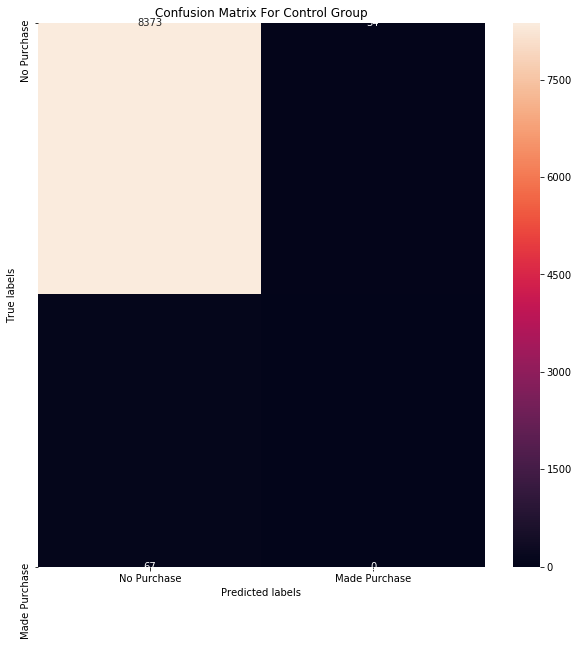

In [45]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_control, control_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Control Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

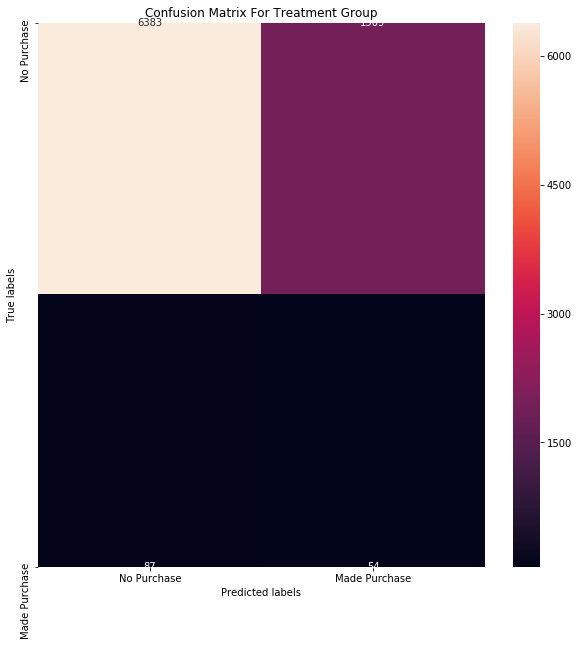

In [46]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_exper, exper_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Treatment Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [47]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]            
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    pred_probs_contol = model_control.predict_proba(test, ntree_limit=model_control.best_ntree_limit)

    pred_probs_exper = model_exper.predict_proba(test, ntree_limit=model_exper.best_ntree_limit)

    # get difference in probabilities between experimental and cpntrol model for purchase = 1 label
    lift = pred_probs_exper[:,1] - pred_probs_contol[:,1]
    
    promotion = []
    
    # Only send promotions to top 3 percentile of probabilities
    cutoff_lift = np.percentile(lift, 97)
    
    for prob in lift:
        if prob > 0:
            if prob > cutoff_lift:
                promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [48]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0176.

Your nir with this strategy is 12.70.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0176197886273747, 12.700000000000003)

### Model 3: Using Treatment Dummy Approach

In this approach, a single model is used to model the data. Unlike the approach used in the first model, this approach adds an additional indicator variable to track if an individual is in a treatment or control group during training. Any individuals who made purchases will be given a label of 1, irregradless of whether he or she is in the control or treatment group.

To predict whether a new individual in a test set is likely to make a purhcase only after receiving a promotion, we can first calculate the probability that the individual will make a purchase if he or she is in the treatment group by setting the treatment indicator as 1. Next, we calculate the probability that the individual will make a purchase if he or she is in the control group by setting the treatment indicator as 0. The difference in the two probabilities will be the lift value, aka, how positively influenced the individual is as a result of the treatment (receiving promotion):

![$$Lift = P(purchase | I_{treat} = 1) - P(purchase |  I_{treat} = 0)$$](https://render.githubusercontent.com/render/math?math=Lift%20%3D%20P%28purchase%20%7C%20I_%7Btreat%7D%20%3D%201%29%20-%20P%28purchase%20%7C%20%20I_%7Btreat%7D%20%3D%200%29&mode=display)

We can opt to send promotions to individuals with prostive lift values. Using this approach for this dataset, an irr of 1.42\% and an nlr of -\$47.40 is obtained for the validation set. On the other hand, the irr and nlr values for the test set is 1.54\% and \\$42.60 respectively. Such a drastic difference between the validation and test nlrs is certainly surprising. The test results does seem to suggest that this is could be a relatively good approach as well. Alternative models, new feature generation and alternative upsampling methods could be tried to improve the results. In addition, you can also choose to send promotions only to individuals with lift values above a certain percentile.

This approach is a slight modification of the method proposed by Victor Lo in the previously mentioned presentation, which can be found [here](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation). The original method proposes a logistic regression model.


In [49]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [50]:
# encode Promotion as 0 or 1 indicator variable
train_data['treatment'] = np.where(train_data['Promotion'] == "Yes", 1, 0)
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,treatment
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,0
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,0
2,4,No,0,2,30.431659,0.133583,1,1,4,2,0
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,0
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,1


In [51]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'treatment']

Y_train = train['purchase']
X_train = train[features]

Y_valid = valid['purchase']
X_valid = valid[features]

In [52]:
# up sample with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [53]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.916298	validation_1-auc:0.654634
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.919459	validation_1-auc:0.660875
[2]	validation_0-auc:0.928347	validation_1-auc:0.654825
[3]	validation_0-auc:0.932595	validation_1-auc:0.645971
[4]	validation_0-auc:0.935008	validation_1-auc:0.647883
[5]	validation_0-auc:0.934159	validation_1-auc:0.646341
[6]	validation_0-auc:0.937256	validation_1-auc:0.641421
[7]	validation_0-auc:0.943894	validation_1-auc:0.641898
[8]	validation_0-auc:0.947674	validation_1-auc:0.641579
[9]	validation_0-auc:0.951958	validation_1-auc:0.642712
[10]	validation_0-auc:0.953071	validation_1-auc:0.640663
[11]	validation_0-auc:0.955449	validation_1-auc:0.639448
[12]	validation_0-auc:0.956925	validation_1-auc:0.638436
[13]	validation_0-auc:0.95936	validation_1-auc:0.639407
[14]	validation_0-auc:0.960672	validation_1-auc:0.63744


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

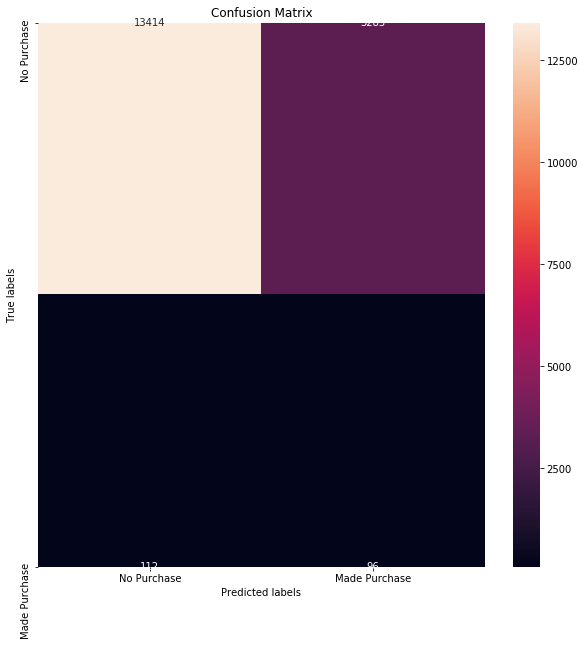

In [54]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [55]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # Fit a model with treatment = 1 for all data points
    test['treatment'] = 1.0
    preds_treat = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    # Fit a model with treatment = 0 for all data points
    test['treatment'] = 0.0
    preds_cont = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    lift = preds_treat[:,1] - preds_cont[:,1]
    
    promotion = []
    
    for prob in lift:
        if prob > 0:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [58]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy);

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0154.

Your nir with this strategy is 42.60.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


/Users/francis/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/francis/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Model 4: Four Quadrant Method

Like model 3, this approach is first suggested by Victor Lo in the [presentation](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation). It suggested designing a model to predict an individual's probability of being in any of the 4 groups: TR, CR, TN, CN.

TR: Treatment and Responded. Basically received promotion and made a purchase CR: Control and Responded. Did not receive a promotion but made a purchase TN: Treatment and No Response. Received promotion but made no purchase CN: Control and No Response. Did not receive a promotion and made no purchase

If an individual's TR probability is the highest among the four groups, it is likely that we will benefit by sending the individual a promotion to induce him or her to make a purchase.In other words, if for an individual:

![$$ max[P(TR), P(CR), P(TN), P(CN)] = P(TR)$$](https://render.githubusercontent.com/render/math?math=max%5BP%28TR%29%2C%20P%28CR%29%2C%20P%28TN%29%2C%20P%28CN%29%5D%20%3D%20P%28TR%29&mode=display)

we should send a promotion.

This model achieved an IRR of 1.56\% and NLR of -\$0.30 on the validation set, and an IRR of 1.55\% and NLR of \\$5.90 on the test set. This model's performance among the validation and test set is relatively stable, but it certainly did not generate very favourable results. Still, it does seem to produce a small positive NLR on the test set.

Alternative models, feature generation, and upsampling techniques can be tried to improve the results.


In [59]:
train_data = pd.read_csv('./training.csv')
test_data = pd.read_csv('./Test.csv')

In [60]:
target = []
for index, row in train_data.iterrows():
    if (row['Promotion'] == "Yes") & (row['purchase'] == 1):
        # TR group
        target.append(0)
    elif (row['Promotion'] == "No") & (row['purchase'] == 1):
        # CR group
        target.append(1)
    elif (row['Promotion'] == "Yes") & (row['purchase'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

train_data['target'] = target
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7,target
0,1,No,0,2,30.443518,-1.165083,1,1,3,2,3
1,3,No,0,3,32.159350,-0.645617,2,3,2,2,3
2,4,No,0,2,30.431659,0.133583,1,1,4,2,3
3,5,No,0,0,26.588914,-0.212728,2,1,4,2,3
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2,2


In [61]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']

Y_train = train['target']
X_train = train[features]

Y_valid = valid['target']
X_valid = valid[features]

In [62]:
Y_train.value_counts()

3    33444
2    33351
0      580
1      252
Name: target, dtype: int64

In [63]:
# up sample with SMOTE
sm = SMOTE({0:33444, 1:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

3    33444
2    33444
1    33444
0    33444
dtype: int64

In [64]:
X_train_upsamp.head()

,V1,V2,V3,V4,V5,V6,V7
0,3.0,34.470493,-1.078506,1.0,1.0,1.0,2.0
1,1.0,28.065819,-1.165083,1.0,1.0,3.0,1.0
2,1.0,27.142590,-1.511395,1.0,3.0,3.0,2.0
3,3.0,28.782344,-1.078506,1.0,1.0,1.0,2.0
4,2.0,39.605508,-0.645617,2.0,3.0,1.0,2.0


In [66]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          num_class=4,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[0]	validation_0-mlogloss:1.3395	validation_1-mlogloss:1.35543
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.29846	validation_1-mlogloss:1.32798
[2]	validation_0-mlogloss:1.26209	validation_1-mlogloss:1.30372
[3]	validation_0-mlogloss:1.22937	validation_1-mlogloss:1.28117
[4]	validation_0-mlogloss:1.19964	validation_1-mlogloss:1.26115
[5]	validation_0-mlogloss:1.17264	validation_1-mlogloss:1.24234
[6]	validation_0-mlogloss:1.14753	validation_1-mlogloss:1.22489
[7]	validation_0-mlogloss:1.12461	validation_1-mlogloss:1.20859
[8]	validation_0-mlogloss:1.10319	validation_1-mlogloss:1.19387
[9]	validation_0-mlogloss:1.08088	validation_1-mlogloss:1.1792
[10]	validation_0-mlogloss:1.06144	validation_1-mlogloss:1.16579
[11]	validation_0-mlogloss:1.04481	validation_1-mlogloss:1.1538
[12]	validation_0-mlogloss:1.02801	validation_1-mlogloss:1.1426
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=True, subsample=1, verbosity=1)

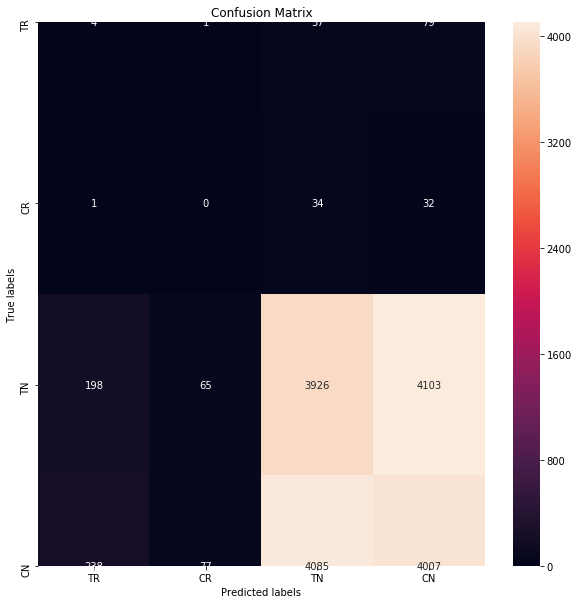

In [67]:
# confusion marix for thge validation set
# Note:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

In [68]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    
    promotion = []
    
    for pred in pred:
        if pred == 0:
            promotion.append('Yes')
        else:
            promotion.append('No')
    
    promotion = np.array(promotion)
    
    return promotion

In [69]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0155.

Your nir with this strategy is 5.90.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.015464544490973224, 5.900000000000006)